Датасет California Housing Prices содержит информацию о домах, расположенных в определённом округе Калифорнии, а также сводную статистику по ним, основанную на данных переписи 1990 года. Основная цель - предсказание средней стоимости дома в различных кварталах Калифорнии.

Столбцы в датасете: <br>
longitude - Долгота (географическая координата) <br>
latitude - Широта (географическая координата) <br>
housing_median_age - Средний возраст дома в квартале; чем меньше число, тем новее здание <br>
total_rooms - Общее количество комнат в квартале <br>
total_bedrooms - Общее количество спален в квартале <br>
population - Общее количество людей, проживающих в квартале <br>
households - Количество домохозяйств в квартале, то есть групп людей, проживающих в одном жилом помещении, в квартале <br>
median_income - Средний доход домохозяйств в квартале (измеряется в десятках тысяч долларов США) <br>
ocean_proximity - Расположение дома относительно океана/моря <br><br>
median_house_value - Средняя стоимость жилья для домохозяйств в пределах квартала (в долларах США) - целевая переменная. <br>

<br>
1. Загрузка датасета California Housing Prices; первичный анализ.
<br>
Сразу удаляем переменные longitude и latitud, потому что это геоданные, а также ocean_proximity, потому что это категориальный признак.

In [72]:
import kagglehub
import pandas as pd
import os
import numpy as np
from scipy.stats import skew, kurtosis, rankdata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import t

path = kagglehub.dataset_download("camnugent/california-housing-prices")
file_path = os.path.join(path, "housing.csv")
df = pd.read_csv(file_path, sep=',')


columns_to_drop = ['longitude', 'latitude', 'ocean_proximity']
df = df.drop(columns=columns_to_drop)
df = df.replace('?', pd.NA).dropna()

print(f"Размер: {df.shape}")
print(df.describe())

Размер: (20433, 7)
       housing_median_age   total_rooms  total_bedrooms    population  \
count        20433.000000  20433.000000    20433.000000  20433.000000   
mean            28.633094   2636.504233      537.870553   1424.946949   
std             12.591805   2185.269567      421.385070   1133.208490   
min              1.000000      2.000000        1.000000      3.000000   
25%             18.000000   1450.000000      296.000000    787.000000   
50%             29.000000   2127.000000      435.000000   1166.000000   
75%             37.000000   3143.000000      647.000000   1722.000000   
max             52.000000  39320.000000     6445.000000  35682.000000   

         households  median_income  median_house_value  
count  20433.000000   20433.000000        20433.000000  
mean     499.433465       3.871162       206864.413155  
std      382.299226       1.899291       115435.667099  
min        1.000000       0.499900        14999.000000  
25%      280.000000       2.563700    

In [73]:
numeric_columns = df.select_dtypes(include=[np.number]).columns

print("\nАсимметрия:")
for col in numeric_columns:
    skew_val = skew(df[col].dropna())
    print(f"{col:20s}: {skew_val:8.3f}")

print("\nЭксцесс:")
for col in numeric_columns:
    kurt_val = kurtosis(df[col].dropna())
    print(f"{col:20s}: {kurt_val:8.3f}")

print("\nМода:")
for col in numeric_columns:
    mode_value = df[col].mode()
    print(f"{col:20s}: {mode_value.iloc[0]}")


Асимметрия:
housing_median_age  :    0.062
total_rooms         :    4.159
total_bedrooms      :    3.459
population          :    4.960
households          :    3.414
median_income       :    1.644
median_house_value  :    0.978

Эксцесс:
housing_median_age  :   -0.801
total_rooms         :   32.706
total_bedrooms      :   21.980
population          :   74.042
households          :   22.088
median_income       :    4.942
median_house_value  :    0.328

Мода:
housing_median_age  : 52.0
total_rooms         : 1527.0
total_bedrooms      : 280.0
population          : 891.0
households          : 306.0
median_income       : 3.125
median_house_value  : 500001.0


2. Визуализация распределения признаков

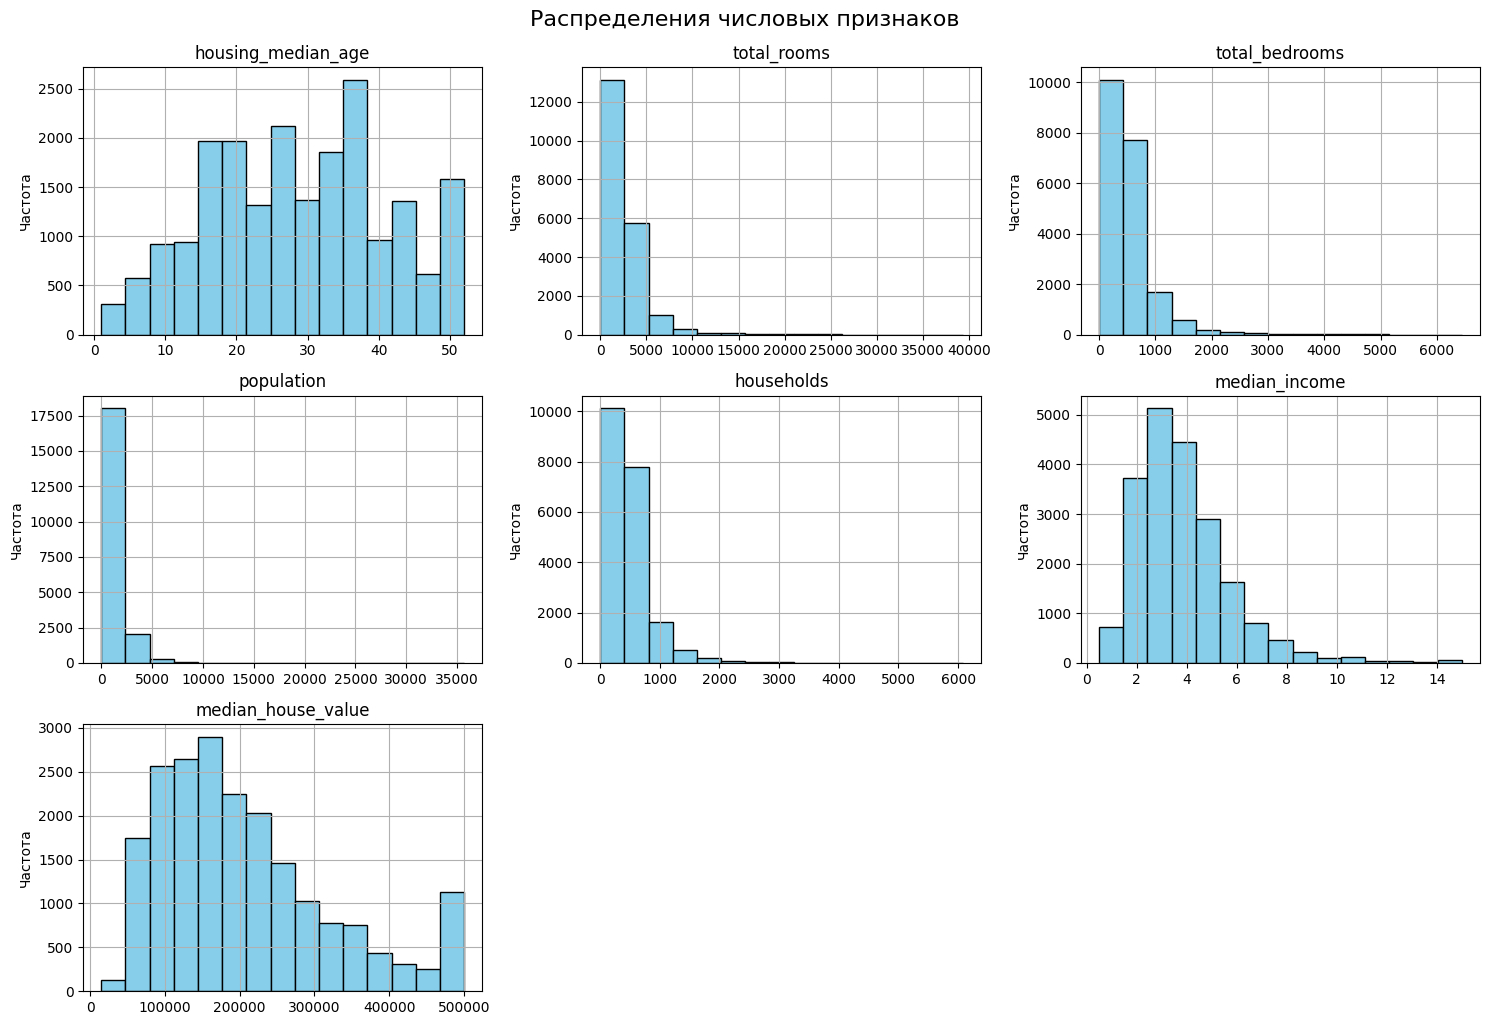

In [74]:
import matplotlib.pyplot as plt
import math

count_intervals = int(1 + math.log2(df.shape[0]))
numeric_cols = df.columns

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    df[col].hist(bins=count_intervals, ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'{col}')
    axes[i].set_ylabel('Частота')
axes[-1].axis('off')
axes[-2].axis('off')
plt.tight_layout()
plt.suptitle("Распределения числовых признаков", y=1.02, fontsize=16)
plt.show()

Анализ распределений<br><br>
2.1 housing_median_age<br>
Ассиметрия: 0.060 - почти нулевая ассиметрия<br>
Эксцесс: -0.801 - плосковершинное распределение<br>
Среднее: 28.64, Медиана: 29.0 - почти совпадают<br>
Итог: распределение близко к нормальному, но не является им.<br><br>
2.2 total_rooms<br>
Ассиметрия: 4.147 - сильно правосторонняя ассиметрия<br>
Эксцесс: 32.623 - островершинное распределение<br>
Среднее: 2635.76, Медиана: 2127 - среднее > медиана<br>
Итог: распределение не является нормальным.<br><br>
2.3 total_bedrooms<br>
Ассиметрия: 3.459 - сильная правосторонняя ассиметрия<br>
Эксцесс: 21.980 - островершинное распределение<br>
Среднее: 537.87, Медиана: 435 - среднее > медиана<br>
Итог: распределение не является нормальным.<br><br>
2.4 population<br>
Ассиметрия: 4.935 - очень сильная правосторонняя ассиметрия<br>
Эксцесс: 73.535 - островершинное распределение<br>
Среднее: 1425.48, Медиана: 1166 - среднее > медиана<br>
Итог: распределение не является нормальным.<br><br>
2.5 households<br>
Ассиметрия: 3.410 - сильная правосторонняя ассиметрия<br>
Эксцесс: 22.052 - островершинное распределение<br>
Среднее: 499.54, Медиана: 409 - среднее > медиана<br>
Итог: распределение не является нормальным.<br><br>
2.6 median_income<br>
Ассиметрия: 1.647 - умеренная правосторонняя ассиметрия<br>
Эксцесс: 4.951 - островершинное распределение<br>
Среднее: 3.87, Медиана: 3.53 - среднее > медиана<br>
Итог: распределение не является нормальным.<br><br>
2.7 median_house_value<br>
Ассиметрия: 0.978 - умеренная правосторонняя ассиметрия<br>
Эксцесс: 0.328 - распределение близко к нормальному<br>
Среднее: 206855.82, Медиана: 179700 - среднее > медиана<br>
Итог: распределение близко к нормальному, но не является им.<br>

Коэффициент корреляции Пирсона и Спирмена (применяем, так как не нормальные распределения)

In [75]:
features = numeric_columns

corr_pearson = df[features].corr(method='pearson')
corr_spearman = df[features].corr(method='spearman')

# Преобразуем в "длинный" формат
pearson_df = corr_pearson.stack().reset_index()
pearson_df.columns = ['Variable_1', 'Variable_2', 'Pearson']

spearman_df = corr_spearman.stack().reset_index()
spearman_df.columns = ['Variable_1', 'Variable_2', 'Spearman']

# Объединяем по парам признаков
comparison_df = pd.merge(pearson_df, spearman_df, on=['Variable_1', 'Variable_2'])

# Убираем диагональ (корреляция признака с самим собой)
comparison_df = comparison_df[comparison_df['Variable_1'] != comparison_df['Variable_2']]

# Сбрасываем индекс
comparison_df.reset_index(drop=True, inplace=True)

# Функция для определения силы связи по таблице
def get_strength_description(r):
    if abs(r) < 0.1:
        return 'очень слабая'
    elif 0.1 <= abs(r) < 0.3:
        return 'слабая'
    elif 0.3 <= abs(r) < 0.5:
        return 'умеренная'
    elif 0.5 <= abs(r) < 0.7:
        return 'заметная'
    elif 0.7 <= abs(r) < 0.9:
        return 'высокая'
    else:
        return 'очень высокая'

# Функция для вычисления t-статистики и p-value
def calculate_significance(r, n):
    df = n - 2
    if abs(r) >= 1.0:  # Защита от деления на ноль или NaN
        t_stat = np.inf if r > 0 else -np.inf
    else:
        t_stat = r * np.sqrt(df) / np.sqrt(1 - r**2)
    
    # Критическое значение t при α=0.05 и df
    t_critical = t.ppf(1 - 0.05 / 2, df)  # двусторонний тест
    is_significant = abs(t_stat) >= t_critical
    return t_stat, 'Значим' if is_significant else 'Не значим'

n = df.shape[0]

comparison_df['Pearson_Strength'] = comparison_df['Pearson'].apply(get_strength_description)
comparison_df['Spearman_Strength'] = comparison_df['Spearman'].apply(get_strength_description)

for col in ['Pearson', 'Spearman']:
    comparison_df[[f'{col}_t_stat', f'{col}_Significant']] = comparison_df.apply(
        lambda row: pd.Series(calculate_significance(row[col], n)), axis=1
    )

print(f"\nКритическое t-значение при α=0.05 и df={n-2}: {t.ppf(1 - 0.05 / 2, n-2):.4f}")
print(comparison_df)


Критическое t-значение при α=0.05 и df=20431: 1.9601
            Variable_1          Variable_2   Pearson  Spearman  \
0   housing_median_age         total_rooms -0.360628 -0.356115   
1   housing_median_age      total_bedrooms -0.320451 -0.306544   
2   housing_median_age          population -0.295787 -0.282934   
3   housing_median_age          households -0.302768 -0.280869   
4   housing_median_age       median_income -0.118278 -0.146260   
5   housing_median_age  median_house_value  0.106432  0.075420   
6          total_rooms  housing_median_age -0.360628 -0.356115   
7          total_rooms      total_bedrooms  0.930380  0.915021   
8          total_rooms          population  0.857281  0.815682   
9          total_rooms          households  0.918992  0.906487   
10         total_rooms       median_income  0.197882  0.270594   
11         total_rooms  median_house_value  0.133294  0.205060   
12      total_bedrooms  housing_median_age -0.320451 -0.306544   
13      total_bedrooms

На основании корреляционного анализа можно сделать предположение о наличии таких скрытых факторов, как плотность населения (количество человек на единицу площади), уровень урбанизации (индекс урбанизации, расстояние до центра), тип жилого массива (средняя этажность, площадь участков), что подтверждается высокими значениями корреляции между признаками population, households, total_rooms, total_bedrooms.

Плотность населения (количество человек на единицу площади): <br>
Наблюдается очень высокая корреляция между признаками population, households, total_rooms и total_bedrooms. Например:
population - households: 0.91 ,
total_rooms - households: 0.92,
population - total_rooms: 0.86.
Это указывает на тесную взаимосвязь между количеством людей и количеством жилых помещений, что прямо отражает плотность населения — чем больше людей, тем больше домов и комнат в районе. <br><br>
Уровень урбанизации (индекс урбанизации, расстояние до центра): <br>
Признак housing_median_age умеренно коррелирует с признаками, отражающими плотность (например, housing_median_age - total_rooms: -0.36, housing_median_age - households: -0.30).
Это может говорить о различиях в уровне урбанизации между старыми и новыми районами: старые районы могут быть менее плотно застроены, тогда как новые районы — более урбанизованы.
Также высокие корреляции между population, households, total_rooms и total_bedrooms указывают на районы с высокой застройкой, что характерно для центральных или более развитых районов.<br><br>
Тип жилого массива (средняя этажность, площадь участков):<br>
Сильные корреляции между total_bedrooms - households (0.98) и total_rooms - households (0.92) могут указывать на размер и тип жилья в районе: например, в частном секторе больше площадь участков и меньше комнат на домохозяйство, а в многоэтажках — наоборот.
Умеренная отрицательная корреляция housing_median_age с этими признаками (например, -0.36 с total_rooms) может говорить о том, что в старых районах застройка отличается по типу и этажности, в сравнении с новыми.

5. Построение матрицы корреляций

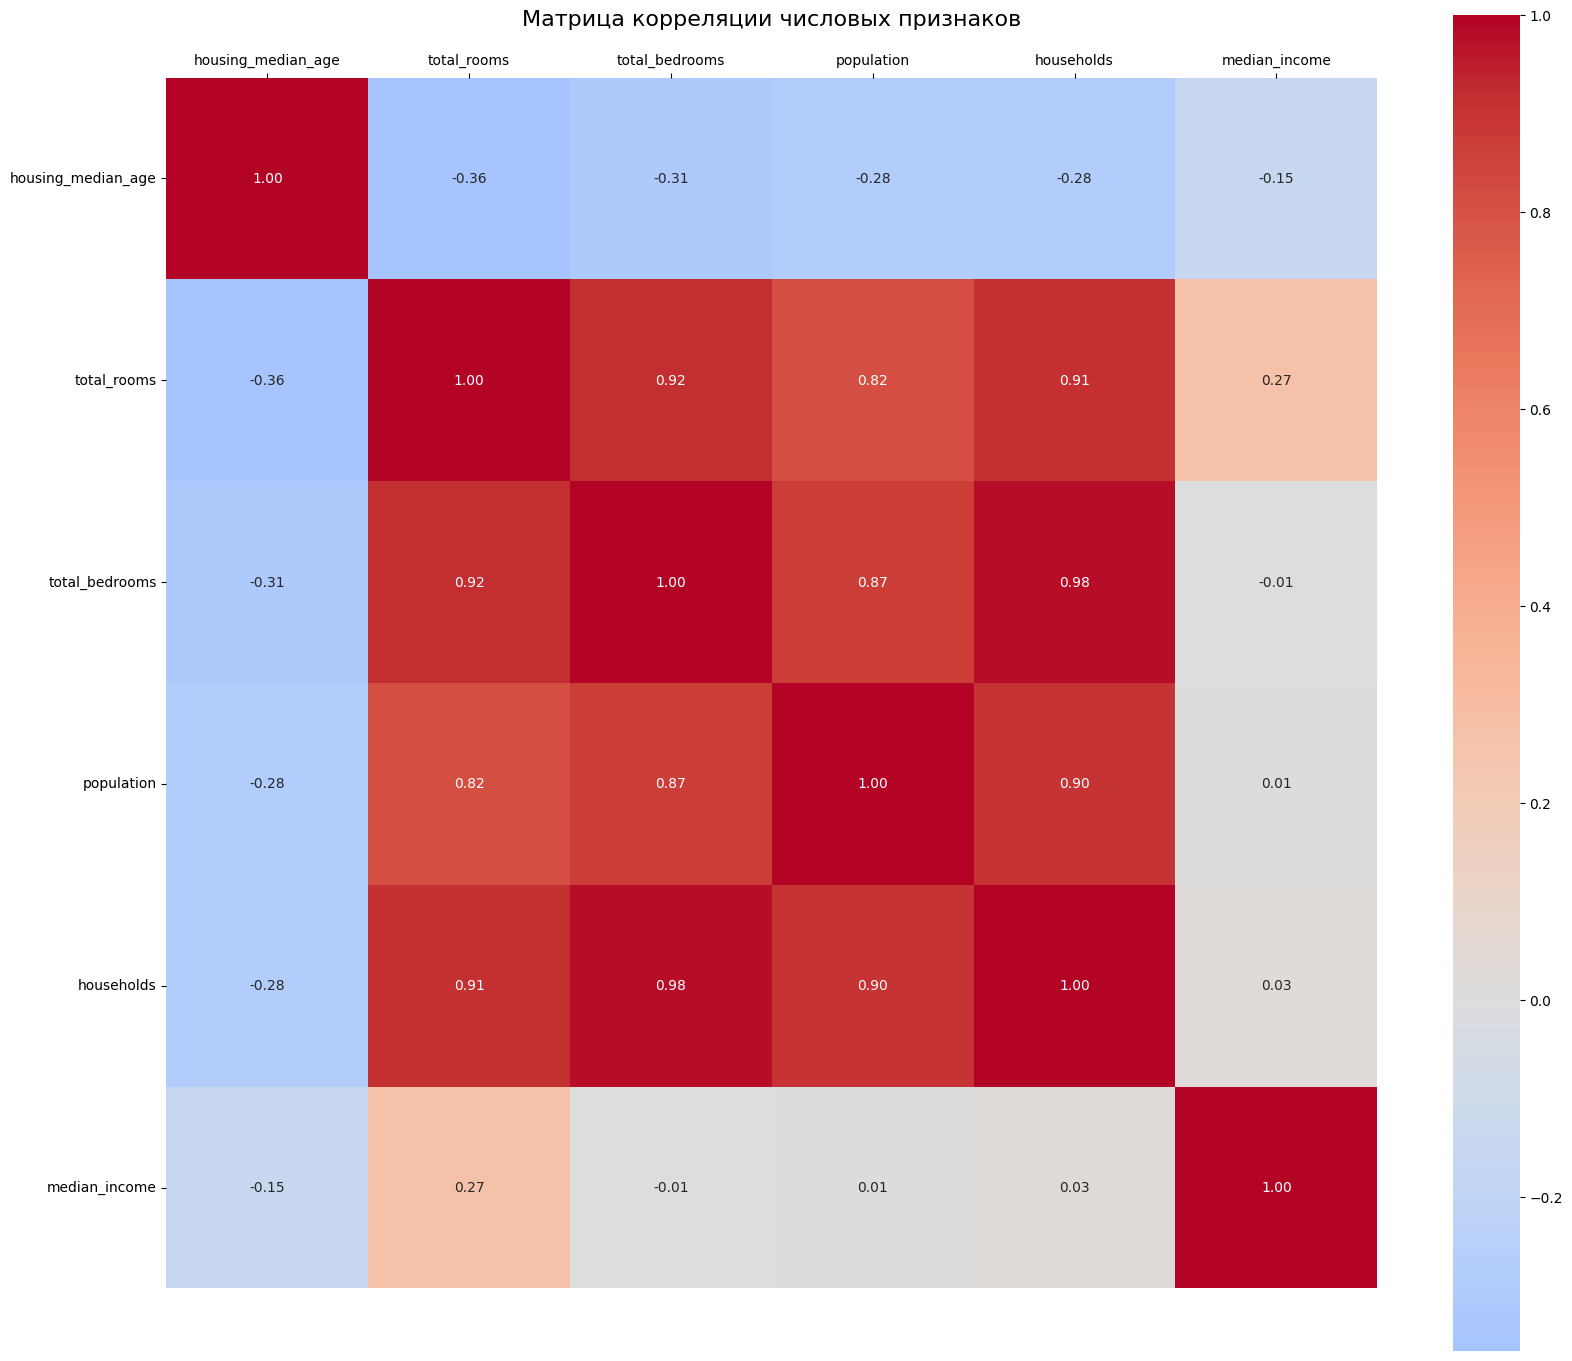


Корреляция с целевой переменной (median_house_value):
median_income: 0.677
total_rooms: 0.205
households: 0.112
total_bedrooms: 0.086
housing_median_age: 0.075
population: 0.003


In [76]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(17, 17))

numeric_columns = df.select_dtypes(include=['number']).columns
correlation_matrix = df[numeric_columns].corr(method='spearman')
correlation_matrix_no_target = correlation_matrix.drop('median_house_value', axis=0).drop('median_house_value', axis=1)


sns.heatmap(correlation_matrix_no_target, 
            annot=True,           
            cmap='coolwarm',      
            center=0,             
            square=True,          
            fmt='.2f',            
            cbar_kws={"shrink": .8},
            xticklabels=correlation_matrix_no_target.columns,  
            yticklabels=correlation_matrix_no_target.columns)  

plt.title('Матрица корреляции числовых признаков', fontsize=16, pad=20)

plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.xaxis.tick_top()       
ax.xaxis.set_label_position('top')  

plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nКорреляция с целевой переменной (median_house_value):")
income_corr = correlation_matrix['median_house_value'].sort_values(key=abs, ascending=False)
for feature, corr_value in income_corr.items():
    if feature != 'median_house_value':
        print(f"{feature}: {corr_value:.3f}")

Сильно коррелируемые признаки: <br>
total_bedrooms и households: 0.98 <br>
total_bedrooms и total_rooms: 0.92 <br>
total_rooms и households: 0.91 <br>
households и population: 0.90 <br>
total_bedrooms и population: 0.87 <br>
total_rooms и population: 0.82 <br>

Диаграммы рассеяния каждого признака с целевой переменной

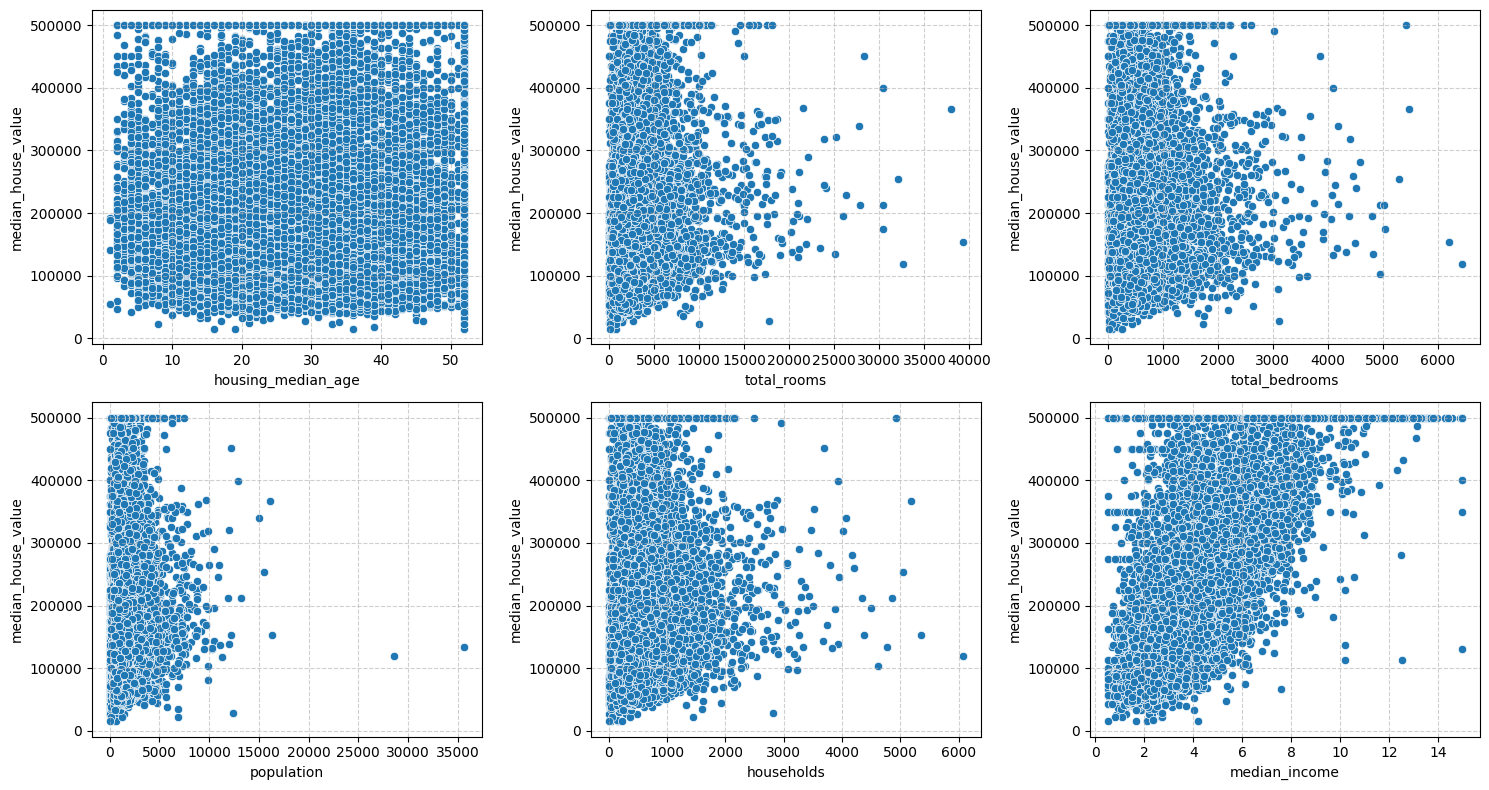

In [77]:
features_to_plot = [col for col in numeric_columns if col != 'median_house_value']

n_features = len(features_to_plot)

ncols = 3
nrows = (n_features + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
axes = axes.flatten() if nrows > 1 else [axes] if n_features == 1 else axes

for i, feature in enumerate(features_to_plot):
    ax = axes[i]
    sns.scatterplot(data=df, x=feature, y='median_house_value', ax=ax)
    ax.grid(True, linestyle='--', alpha=0.6)

# Убираем пустые subplot'ы
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Стандартизация переменных и метод главных компонент (PCA).

Формула стандартизации: <br>
z = (x - μ) / σ, где <br>
x - исходное значение <br>
μ - среднее значение признака <br>
σ - стандартное отклонение признака <br>
z - стандартизированное значение

Доля объясненной дисперсии по компонентам:
Компонента 1: 0.6474 (64.74%)
Компонента 2: 0.1787 (17.87%)
Компонента 3: 0.1354 (13.54%)
Компонента 4: 0.0249 (2.49%)
Компонента 5: 0.0110 (1.10%)
Компонента 6: 0.0025 (0.25%)

Кумулятивная дисперсия:
Первые 1 компонент(ы): 0.6474 (64.74%)
Первые 2 компонент(ы): 0.8262 (82.62%)
Первые 3 компонент(ы): 0.9616 (96.16%)
Первые 4 компонент(ы): 0.9865 (98.65%)
Первые 5 компонент(ы): 0.9975 (99.75%)
Первые 6 компонент(ы): 1.0000 (100.00%)

Оптимальное число компонент для объяснения 95% дисперсии: 3

Размерность до PCA: (20433, 6)
Размерность после PCA: (20433, 3)
Кумулятивная доля дисперсии, объяснённая выбранными компонентами: 0.9616
Факторные нагрузки:
                    Factor_1  Factor_2  Factor_3
housing_median_age -0.218099 -0.405603  0.886588
total_rooms         0.487805  0.087474  0.121951
total_bedrooms      0.493543 -0.119938  0.062412
population          0.473243 -0.116598  0.079095
households          0.494955 -0.113124  0.094716
median

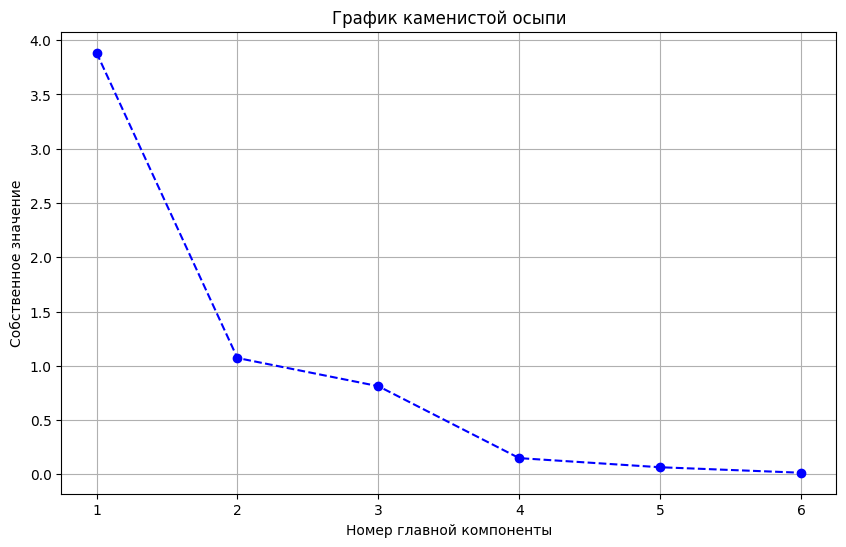

Собственные значения (факторы):
[3.88484422 1.07230177 0.81254793 0.1496799  0.06572176 0.01519809]


In [78]:
from sklearn.decomposition import PCA


features = numeric_columns.drop('median_house_value')

X = df[features]
y = df['median_house_value']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_full = PCA()
pca_full.fit(X_scaled)

explained_variance = pca_full.explained_variance_ratio_

print("Доля объясненной дисперсии по компонентам:")
for i, ratio in enumerate(pca_full.explained_variance_ratio_):
    print(f"Компонента {i+1}: {ratio:.4f} ({ratio*100:.2f}%)")

print(f"\nКумулятивная дисперсия:")
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
for i, cum_var in enumerate(cumsum_var):
    print(f"Первые {i+1} компонент(ы): {cum_var:.4f} ({cum_var*100:.2f}%)")

n_components = np.argmax(cumsum_var >= 0.95) + 1
print(f"\nОптимальное число компонент для объяснения 95% дисперсии: {n_components}")

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

print(f"\nРазмерность до PCA: {X_scaled.shape}")
print(f"Размерность после PCA: {X_pca.shape}")
print(f"Кумулятивная доля дисперсии, объяснённая выбранными компонентами: {sum(pca.explained_variance_ratio_):.4f}")

print("Факторные нагрузки:")
components_df = pd.DataFrame(pca.components_.T, 
                             columns=[f'Factor_{i+1}' for i in range(pca.n_components_)], 
                             index=features)
print(components_df)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca_full.explained_variance_) + 1), pca_full.explained_variance_, marker='o', linestyle='--', color='b')
plt.title('График каменистой осыпи')
plt.xlabel('Номер главной компоненты')
plt.ylabel('Собственное значение')
plt.grid(True)
plt.show()

print('Собственные значения (факторы):')
print(pca_full.explained_variance_)

Судя по графику, первые 4 компоненты объясняют 96.62% всей информации, а остальные — только 3.38%. Также по графику видно, что происходит резкое падение дисперсии после 1-ой компоненты ( у 1 -ой компоненты доля объясненной дисперсии 64.74%, а у 2-ой в разы меньше - 17.87%), затем более пологий спад до 4-й, а потом — почти горизонтальная линия. Локоть находится примерно на 4-й компоненте — именно там добавление новых компонент перестаёт давать значительный прирост объяснённой дисперсии. Это говорит о том, что добавление 5-й и 6-й компонент не даёт существенного прироста информации. Значит, можно уменьшить размерность с 6 до 4 признаков, сохранив практически всю информацию.